the amount of layers we uses: 3
Number of neurons:  4
Activation: sigmoid 

Number of neurons:  4
Activation: sigmoid 

Number of neurons:  1
Activation: sigmoid 

Epoch 0 loss : 0.24891065760766548
Epoch 500 loss : 0.23920449471598468
Epoch 1000 loss : 0.21493779533036278
Epoch 1500 loss : 0.19091968417369262
Epoch 2000 loss : 0.17549243702026085
Epoch 2500 loss : 0.165888682009159
Epoch 3000 loss : 0.07081737703497369
Epoch 3500 loss : 0.02815890065646854
Epoch 4000 loss : 0.012742882604475484
Epoch 4500 loss : 0.006451339697982084
Epoch 5000 loss : 0.00384400609999982
Epoch 5500 loss : 0.0025885523786194943
Epoch 6000 loss : 0.0018934590960200076
Epoch 6500 loss : 0.0014661470642421852
Epoch 7000 loss : 0.001182441395904239
Epoch 7500 loss : 0.000982896821917151
Epoch 8000 loss : 0.0008361815635914764
Epoch 8500 loss : 0.0007244715785471874
Epoch 9000 loss : 0.000636986469098919
Epoch 9500 loss : 0.0005668721660282506
[[1.44398188e-04]
 [9.98700983e-01]
 [5.56219872e-04]
 [9.9864272

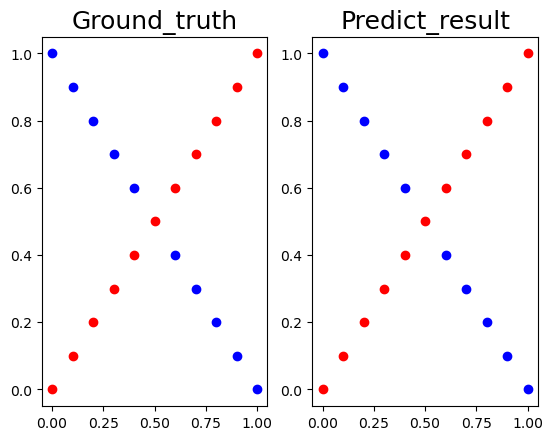

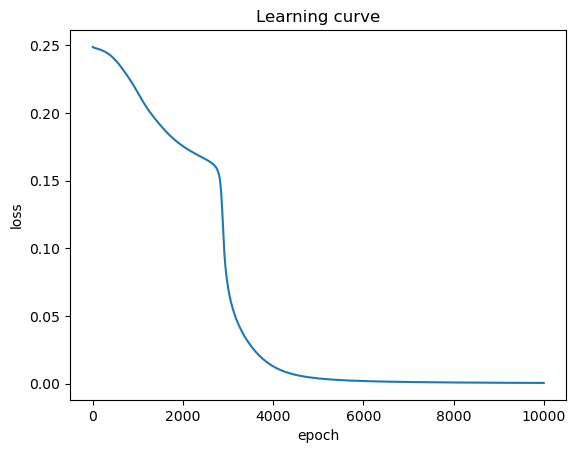

In [67]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

""" create dataset """
def generate_linear(n = 100):
    pts = np.random.uniform(0,1,(n,2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n,1)

def generate_XOR_easy():
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1 * i, 0.1 * i])
        labels.append(0)
        
        if  0.1 * i == 0.5: continue
        
        inputs.append([0.1 * i, 1 - 0.1 * i])
        labels.append(1)
    return np.array(inputs), np.array(labels).reshape(21,1)

""" Add Layers class ,count the layers what we have """
class Layers :      
    def layer(units = 4, activation = 'sigmoid'):
        return (units, activation)
    
""" two hidden_layer """
class NeuralNetwork:
    def __init__(self):        
        self.allLayer = []
        self.momentum = []
        self.W = []
        self.w_sum = []
        self.z = []
        self.dl_dw = []
        self.activation = []
        self.learning_rate = 1
        self.optimizer = None
        self.epochs = 10000
        self.learning_epoch, self.learning_loss = list(), list()
    
    def set_learning_rate(self, eta):
        self.learning_rate = eta
    
    def set_optimizer(self, optimizer = ''):
        self.optimizer = optimizer
    
    def set_epoch(self, epoch):
        self.epochs = epoch
    
    def Clear(self):
        self.allLayer.clear()
        self.momentum.clear()
        self.W.clear()
        self.w_sum.clear()
        self.z.clear()
        self.dl_dw.clear()
        self.activation.clear()
        self.learning_epoch.clear()
        self.learning_loss.clear()
    
    """ decide what unit & activation func """
    def add(self, layer = (4, '') ):
        self.allLayer.append(layer)
    
    """ Forward Propagation """
    def forward(self, X):
        self.x = X
        a = None
        
        #Looping over layers
        for j in range(0, len(self.allLayer)): 
            if j == 0:
                a = X @ self.W[j] 
            else:
                a = self.z[j-1] @ self.W[j] 
                
            if self.activation[j] == 'sigmoid':
                self.z[j] = self.sigmoid(a, der = False)
            elif self.activation[j] == 'tanh':
                self.z[j] = self.tanh(a, der = False)
            elif self.activation[j] == 'ReLU':
                self.z[j] = self.ReLU(a, der = False)
            else:
                self.z[j] = a  # Without activation function      
           
        return self.z[len(self.allLayer) - 1]
    
    """ Back Propagation """
    def backward(self, ground_truth, pred_y):
        backward_gradient = None        
        for j in range(len(self.z) - 1, -1, -1):
            if j == len(self.z) - 1:
                delta_Out = self.derivative_mse(ground_truth, pred_y)
                
                if self.activation[len(self.allLayer) - j - 1] == 'sigmoid':
                    backward_gradient = np.multiply(self.sigmoid(pred_y, der = True), delta_Out)
                    
                elif self.activation[len(self.allLayer) - j - 1] == 'tanh':
                    backward_gradient = np.multiply(self.tanh(pred_y, der=True), delta_Out)
                    
                elif self.activation[len(self.allLayer) - j - 1] == 'ReLU':
                    backward_gradient = np.multiply(self.ReLU(pred_y, der=True), delta_Out)
                
                self.dl_dw[j] = self.z[j-1].T @ backward_gradient
            else:
                if self.activation[len(self.allLayer) - j - 1] == 'sigmoid':
                    backward_gradient = np.multiply(self.sigmoid(self.z[j], der=True), backward_gradient @ self.W[j+1].T)
                    
                elif self.activation[len(self.allLayer) - j - 1] == 'tanh':
                    backward_gradient = np.multiply(self.tanh(self.z[j], der=True), backward_gradient @ self.W[j+1].T)
                    
                elif self.activation[len(self.allLayer) - j - 1] == 'ReLU':
                    backward_gradient = np.multiply(self.ReLU(self.z[j], der=True), backward_gradient @ self.W[j+1].T)
                    
                if j == 0:
                    self.dl_dw[j] = self.x.T @ backward_gradient
                else:
                    self.dl_dw[j] = self.z[j-1].T @ backward_gradient
    
    """ Back Propagation without activation"""
    def backward_noAct(self, ground_truth, pred_y):
        gradient = None
        for j in range(len(self.z) - 1, -1, -1):
            if j == len(self.z) - 1: 
                gradient = self.derivative_mse(ground_truth, pred_y) 
                self.dl_dw[j] = self.z[j-1].T @ gradient
            elif j == 0:
                gradient = gradient @ self.W[j+1].T
                self.dl_dw[j] = self.x.T @ gradient
            else:
                gradient = gradient @ self.W[j+1].T
                self.dl_dw[j] = self.z[j-1].T @ gradient
                
#         dl_dy = derivative_mse(y, self.pred_y)
#         dy_dw3 = self.a2
#         self.dl_dw3 = dy_dw3.T @ dl_dy

#         dy_da2 = self.w3
#         da2_dw2 = self.a1
#         G2 = (dl_dy @ self.w3.T)
#         self.dl_dw2 = da2_dw2.T @ G2

#         da2_da1 = self.w2
#         da1_dw1 = self.x
#         G3 = (G2 @ self.w2.T)
#         self.dl_dw1 = da1_dw1.T @ G3
                    
    """ Update weights """
    def update(self):
        for j in range(0, len(self.allLayer)):
            self.w_sum[j] = 0
            
        for j in range(0, len(self.allLayer)): 
            if self.optimizer == 'momentum':
                self.momentum[j] = 0.9 * self.momentum[j] - self.learning_rate * self.dl_dw[j]
                self.W[j] += self.momentum[j]
            elif self.optimizer == 'adagrad':
                self.w_sum[j] += (self.W[j] ** 2)
                self.W[j] -= self.learning_rate * self.dl_dw[j] / np.sqrt(self.w_sum[j] + 1e-8)
            else:
                self.W[j] -= self.learning_rate * self.dl_dw[j]
   
    """
    Define the sigmoid activator, the derivative ==> y' = y(1 - y)
    """
    def sigmoid(self, x, der = False):
        if der == True:
            y_prime = np.multiply(x, 1.0 - x)
        else: 
            y_prime  = 1.0 / (1.0 + np.exp(-x))
        return y_prime
    
    """
    Define the Rectifier Linear Unit (ReLU) activator
    the derivative ==> y' = 1 if y > 0 , y' = 0 if y <= 0
    """
    def ReLU(self, x, der = False):
        if der == True:
            y_prime = np.heaviside(x, 1.0)
        else :
            y_prime = np.maximum(x, 0.0)
            
        return y_prime
    
    """
    Define the tanh activator, the derivative ==> y' = 1 - y^2
    """
    def tanh(self, x, der = False):
        if der == True:
            y_prime = 1.0 - x ** 2
        else:
            y_prime = np.tanh(x)
            
        return y_prime
    
    def derivative_mse(self, y, pred_y):
        return -2 * (y - pred_y) / y.shape[0]
    
    """ loss func """
    def loss_mse(self, prediction, ground_truth):
        return np.mean((prediction - ground_truth) ** 2)  
    
    """ print graph """
    def show_result(self, x, y):
        plt.subplot(1,2,1)
        plt.title('Ground_truth', fontsize = 18)
        for i in range(x.shape[0]):
            if y[i] == 0:
                plt.plot(x[i][0], x[i][1], 'ro')
            else:
                plt.plot(x[i][0], x[i][1], 'bo')
        
        pred_y = self.predict(x)
        plt.subplot(1,2,2)
        plt.title('Predict_result', fontsize = 18)
        for i in range(x.shape[0]):
            if pred_y[i] <= 0.5:
                plt.plot(x[i][0], x[i][1], 'ro')
            else:
                plt.plot(x[i][0], x[i][1], 'bo')
        
        pred_y[pred_y > 0.5] = 1
        pred_y[pred_y <= 0.5] = 0
        print(f'Accuracy: {np.sum(pred_y == y) / y.shape[0] * 100}%')
        
        plt.figure()
        plt.title('Learning curve')
        plt.plot(self.learning_epoch, self.learning_loss)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        
        plt.show     

    """ Training Model """
    def fit(self, inputs_list, targets_list):
        self.X = inputs_list
        self.y = targets_list
        
        print('the amount of layers we uses:', len(self.allLayer))
        
        """ initialization """
        self.z = [0] * len(self.allLayer)
        self.w_sum = [0] * len(self.allLayer)
        self.dl_dw = [0] * len(self.allLayer)
        for i in range(0, len(self.allLayer)):
            print('Number of neurons: ', self.allLayer[i][0])
            print('Activation:', self.allLayer[i][1], "\n")
            
            if i == 0:
                self.W.append(np.random.normal(0, 1, (self.X.shape[1], self.allLayer[i][0])))
                self.momentum.append(np.zeros((self.X.shape[1], self.allLayer[i][0])))
            else :
                self.W.append(np.random.normal(0, 1, (self.allLayer[i-1][0], self.allLayer[i][0])))
                self.momentum.append(np.zeros((self.allLayer[i-1][0], self.allLayer[i][0])))
                            
            self.activation.append(self.allLayer[i][1])     # save all activation which we use

        """ evaluate """
        for epoch in range(self.epochs):         
            pred_y = self.forward(self.X)
            loss = self.loss_mse(pred_y, targets_list)            
            self.backward(self.y, pred_y)
#             self.backward_noAct(self.y, pred_y)
            self.update()
            
            if epoch % 500 == 0:
                print(f'Epoch {epoch} loss : {loss}')
            self.learning_epoch.append(epoch)
            self.learning_loss.append(loss)
            
            # if it's loss has already lower than threshold in some epochs, than break
#             if loss < 0.001:
#                 break

    """ Testing """  
    def predict(self, X): 
        outputs = self.forward(X)
        print(outputs)
        return np.round(outputs)

if __name__ == '__main__':
    x, y = generate_linear(n = 100)
#     x, y = generate_XOR_easy()
    
    # set parameter 
    hidden_size1 = 4
    hidden_size2 = 4
    output_size = y.shape[1]
    lr = 0.1
    optimizer = 'momentum'
    epochs = 10000
    
#     show inputs 
#     plt.subplot(1,1,1)
#     for i in range(x.shape[0]):
#         if y[i] == 0:
#             plt.plot(x[i][0], x[i][1], 'ro')
#         else:
#             plt.plot(x[i][0], x[i][1], 'bo')
#     plt.show
    
    model = NeuralNetwork()
#     tanh  ReLu  sigmoid
    """ hiddenlayer1 | hiddenlayer2 | outputlayer """
    model.add(Layers.layer(hidden_size1, 'sigmoid'))     
    model.add(Layers.layer(hidden_size2, 'sigmoid'))     
    model.add(Layers.layer(output_size, 'sigmoid'))  
#     model.add(Layers.layer(hidden_size1, ''))
#     model.add(Layers.layer(hidden_size2, ''))     
#     model.add(Layers.layer(output_size, ''))
    model.set_learning_rate(lr)
    model.set_optimizer(optimizer)
    model.set_epoch(epochs)
    
    model.fit(x, y)
    model.show_result(x,y)
    model.Clear()
